In [13]:
pip install scikit-learn

Note: you may need to restart the kernel to use updated packages.


In [1]:
import pandas as pd
import seaborn as sb
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
import matplotlib.pyplot as plt

In [111]:
csv_file_path = '/Users/Elzantohboonleong/Desktop/UCL/T1_Class/Energy Data analysis/EDA Grp Project/final.data.csv'
data = pd.read_csv(csv_file_path)
#print(data.isnull().sum())
data.shape
#data['day_auction_price_GBP_per_MWh'] = data['day_auction_price_GBP_per_MWh'].abs()
#data.head()
#https://www.kaggle.com/code/samsonqian/predicting-house-prices-with-regression
#https://medium.com/@bhatshrinath41/quick-guide-to-hyperparameter-tuning-dc6e0a1956cf
#https://medium.com/@bhatshrinath41/a-comprehensive-guide-to-random-forest-regression-43da559342bf

(640, 15)

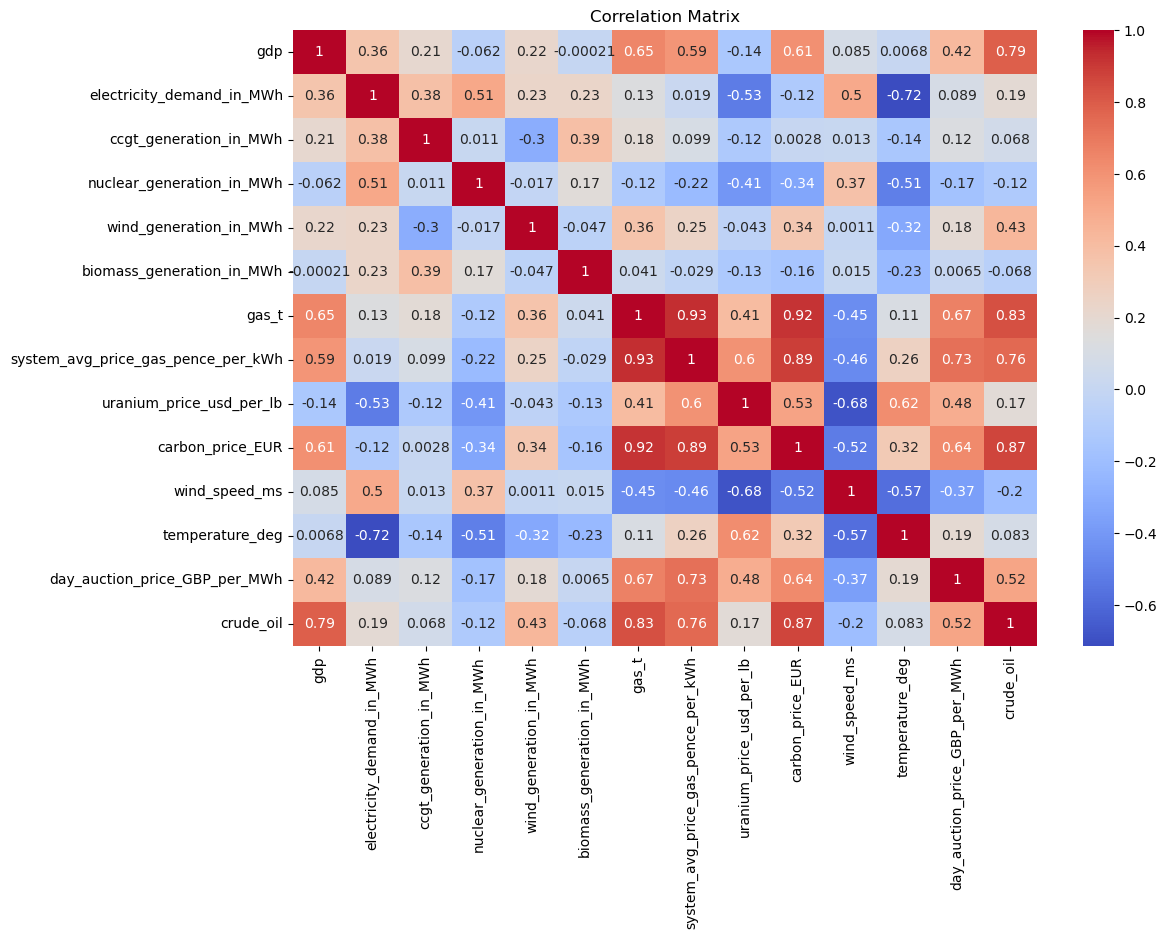

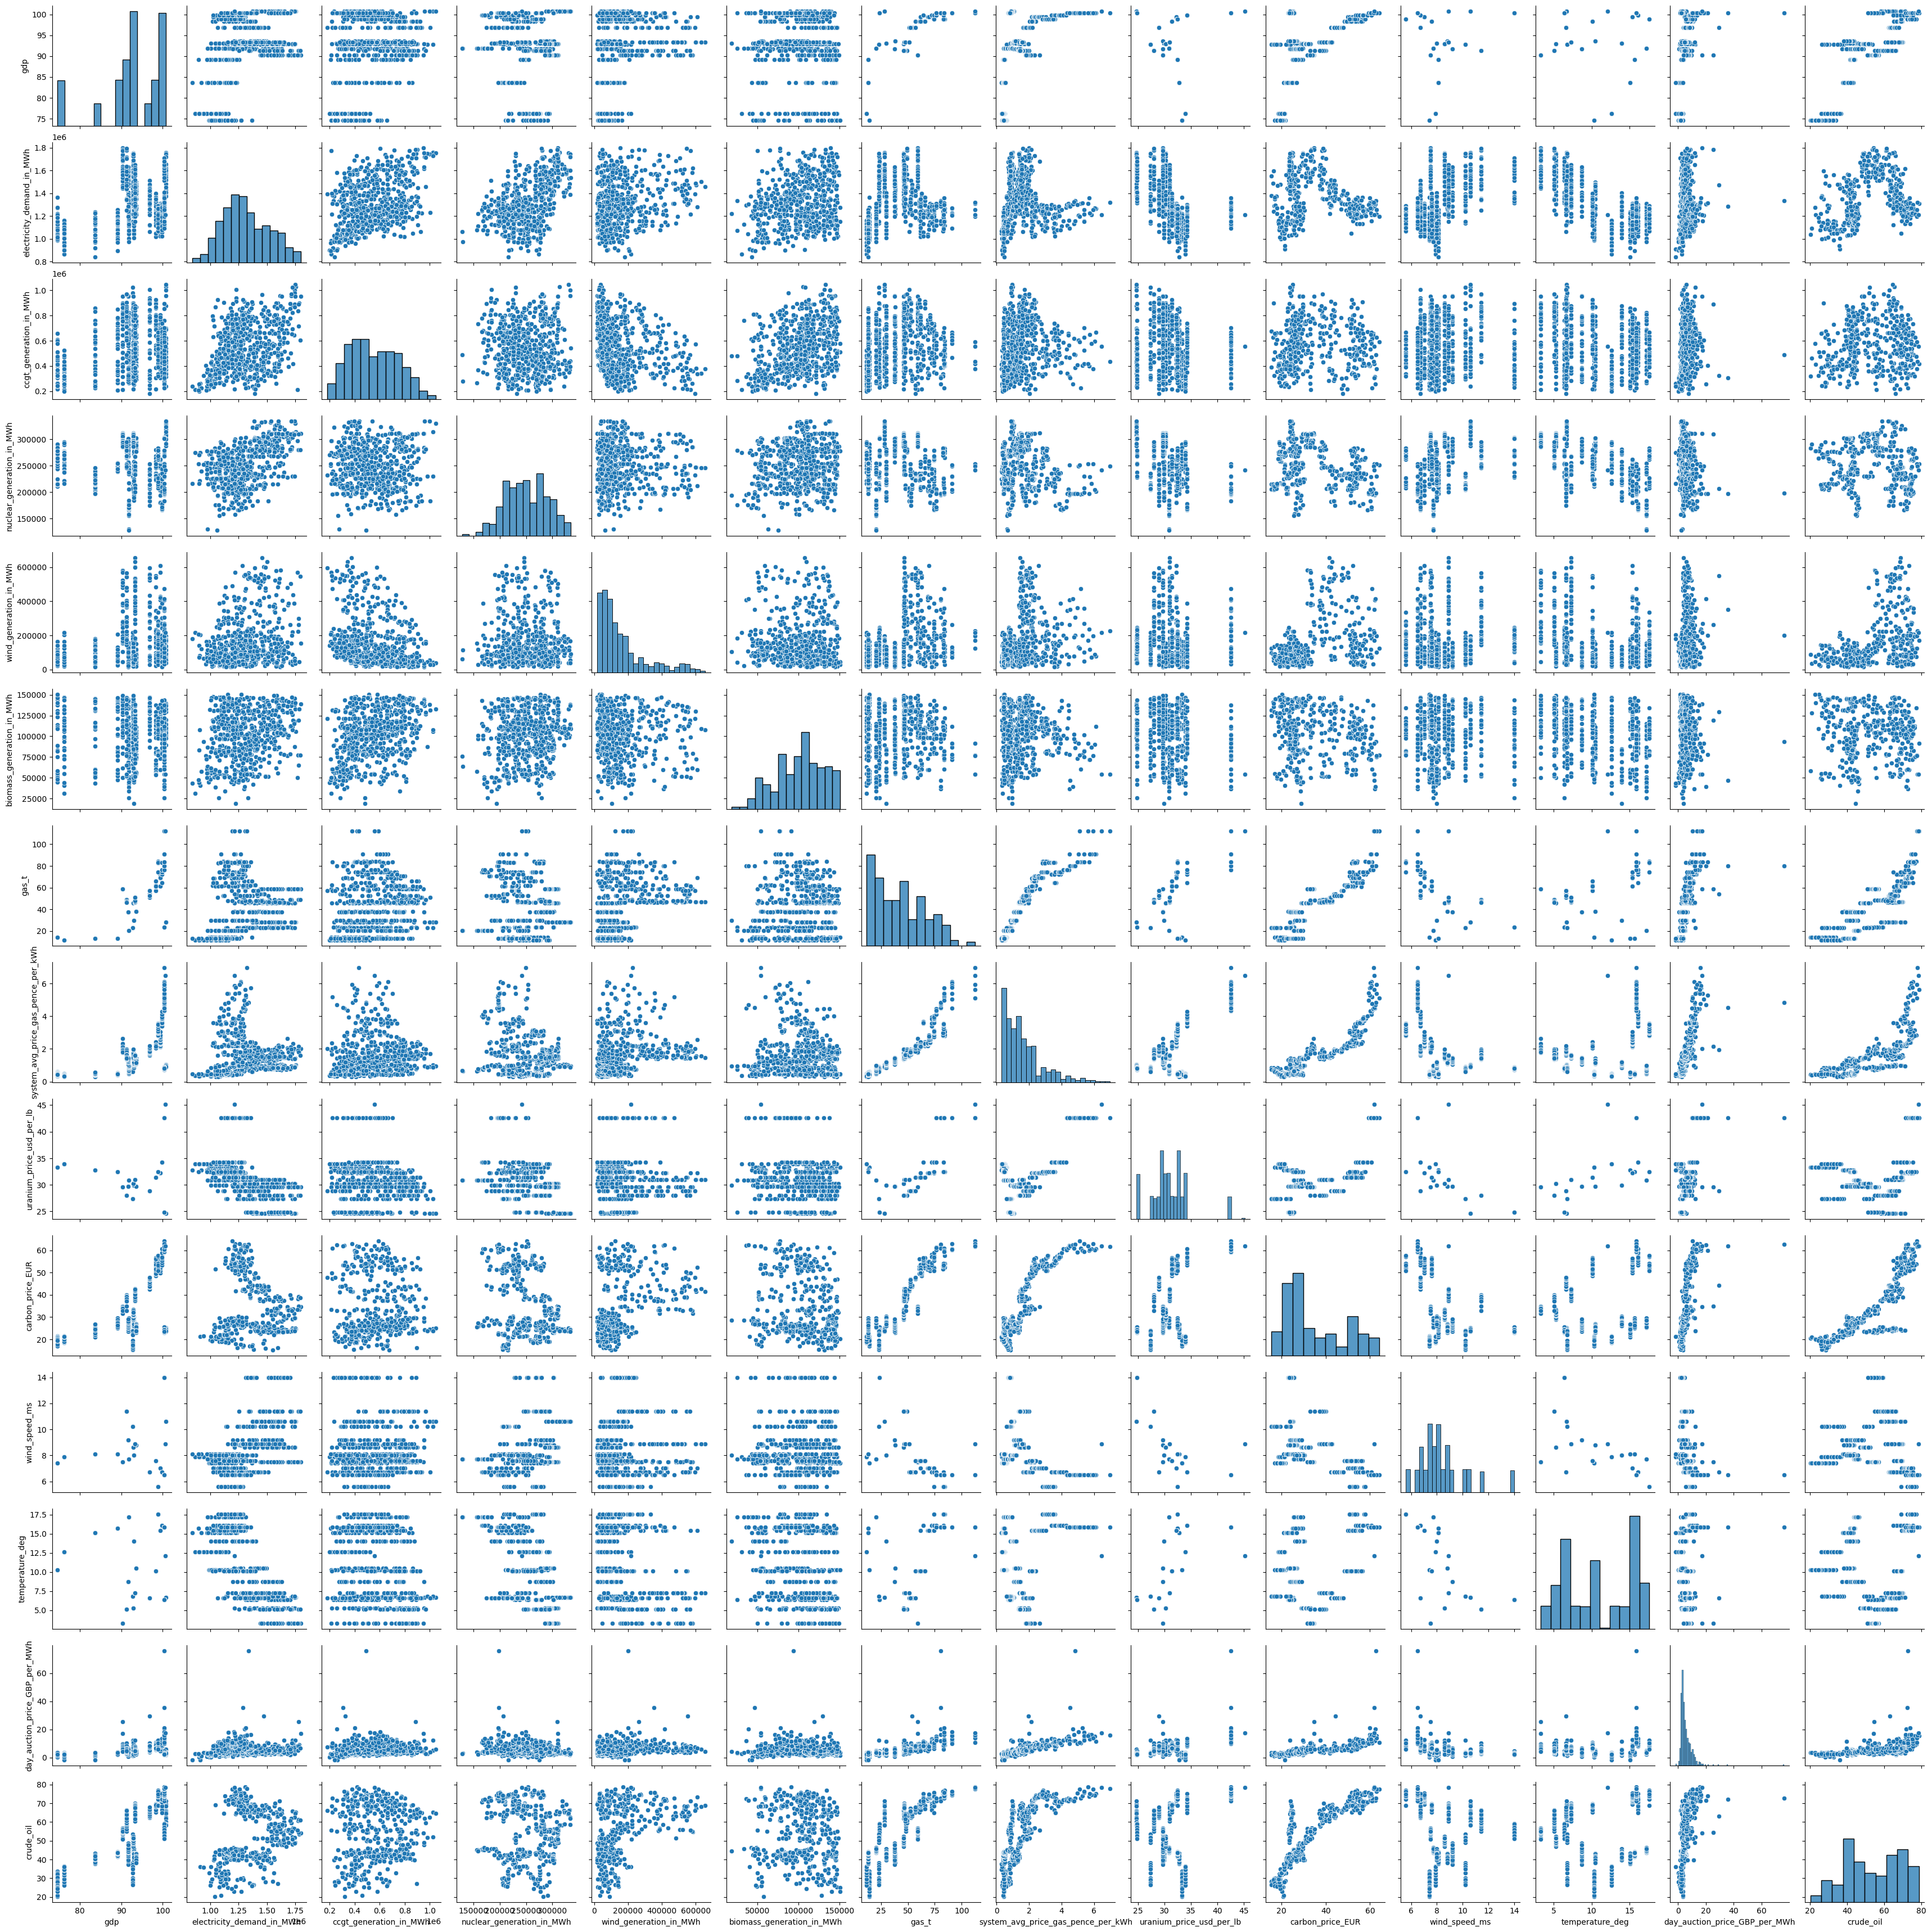

In [3]:
corr_matrix = data.corr(numeric_only=True)
plt.figure(figsize=(12, 8))
sb.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

# scatterplot to visualise any correlation for low correlation values
pearson_pair_plot = sb.pairplot(data)

# Displaying the plot
plt.show()

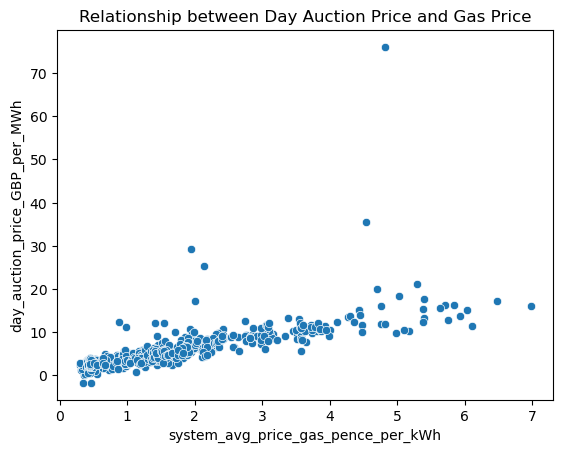

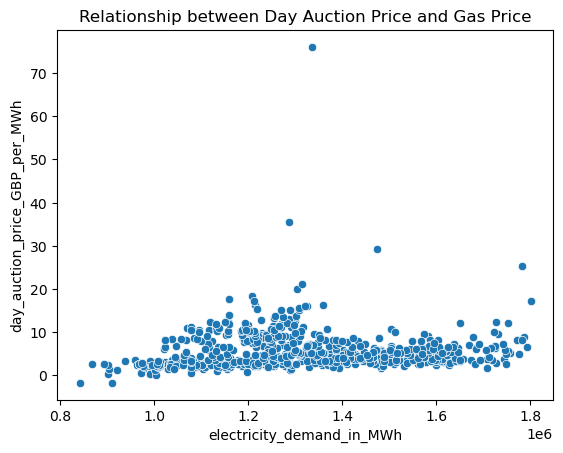

In [14]:
sb.scatterplot(x='system_avg_price_gas_pence_per_kWh', y='day_auction_price_GBP_per_MWh', data=data)
plt.title('Relationship between Day Auction Price and Gas Price')
plt.show()

sb.scatterplot(x='electricity_demand_in_MWh', y='day_auction_price_GBP_per_MWh', data=data)
plt.title('Relationship between Day Auction Price and Gas Price')
plt.show()

In [108]:
data['date'] = pd.to_datetime(data['date'])
data.fillna(method='ffill', inplace=True)
data.fillna(method='bfill', inplace=True)
#data.drop(['date'], axis=1, inplace=True) #permanent removal of the date column
#print(data.isnull().sum())

In [100]:
X = data.drop(['day_auction_price_GBP_per_MWh','date', 'system_avg_price_gas_pence_per_kWh'], axis=1)
y = data['day_auction_price_GBP_per_MWh']
#X_valid = testing.drop("Id", axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
#fix the random state for comparison
#y.head()

<Axes: xlabel='day_auction_price_GBP_per_MWh', ylabel='Count'>

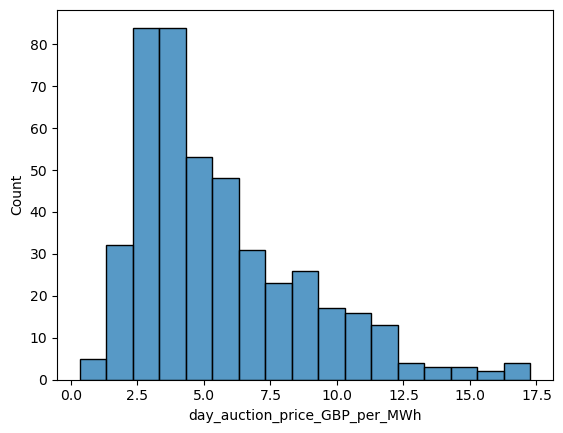

In [29]:
sb.histplot(y_train)

# Standard Random Forest Regression

R^2 Score: 0.7218657578658396
RMSE Score: 1.371927802268139
MAE Score: 0.9566674621582031
MAPE Score: 27.563060736367227%


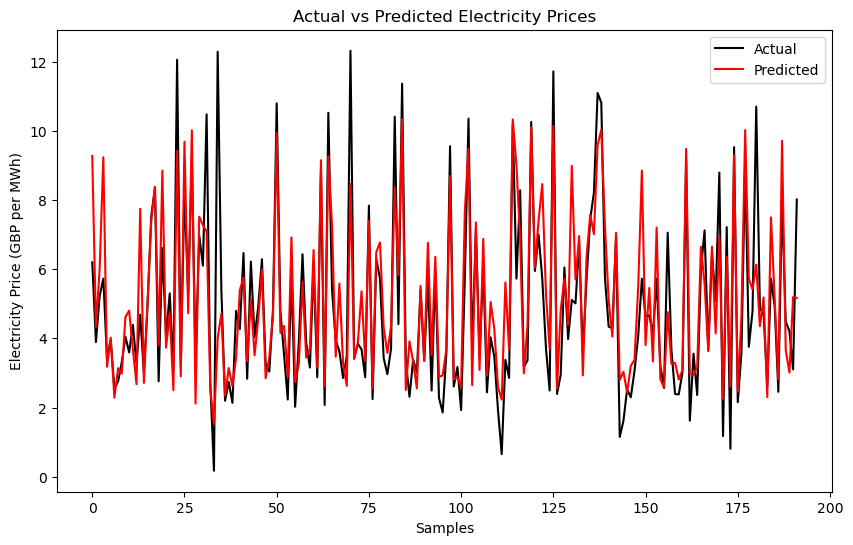

In [113]:
model = RandomForestRegressor(random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

r2_rf = r2_score(y_test, y_pred)
rmse_rf = np.sqrt(mean_squared_error(y_test, y_pred))
mae_rf = mean_absolute_error(y_test, y_pred)
mape_rf = mean_absolute_percentage_error(y_test, y_pred)*100
print("R^2 Score: " + str(r2_rf))
print("RMSE Score: " + str(rmse_rf))
print("MAE Score: " + str(mae_rf))
print("MAPE Score: " + str(mape_rf) + "%")


plt.figure(figsize=(10, 6))
plt.plot(y_test.values, label='Actual', color='black')
plt.plot(y_pred, label='Predicted', color='red')
plt.title('Actual vs Predicted Electricity Prices')
plt.xlabel('Samples')
plt.ylabel('Electricity Price (GBP per MWh)')
plt.legend()
plt.show()


# Effect of Scaling in Random Forest

R^2 Score: 0.638833614788682
RMSE Score: 2.668529313729151
MAE Score: 1.1616586979166665
MAPE Score: 27.280872343772927%


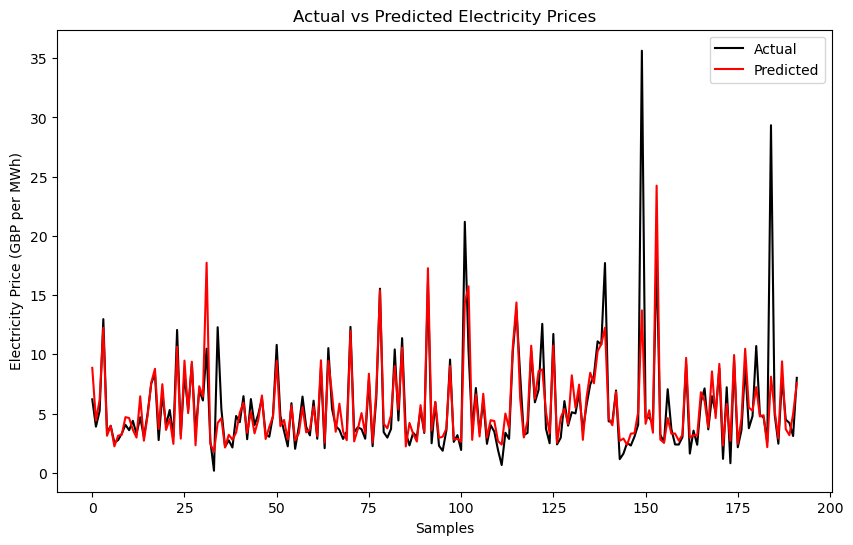

In [87]:
scaler = StandardScaler() #scaling in this case is not necessary because they do not improve the score or mse
X_train_scaled = scaler.fit_transform(X_train) 
X_test_scaled = scaler.transform(X_test) 
#which also aligns to the inherent robustness to scale in random forest
#Also, considering the mixed data types used, there is no binary flags or counts. 
#Mostly continuous measurements

model_scaled = RandomForestRegressor(random_state=42)
model_scaled.fit(X_train_scaled, y_train)
y_pred_scaled = model_scaled.predict(X_test_scaled)

r2_rf = r2_score(y_test, y_pred_scaled)
rmse_rf = np.sqrt(mean_squared_error(y_test, y_pred_scaled))
mae_rf = mean_absolute_error(y_test, y_pred_scaled)
mape_rf = mean_absolute_percentage_error(y_test, y_pred_scaled)*100
print("R^2 Score: " + str(r2_rf))
print("RMSE Score: " + str(rmse_rf))
print("MAE Score: " + str(mae_rf))
print("MAPE Score: " + str(mape_rf) + "%")

plt.figure(figsize=(10, 6))
plt.plot(y_test.values, label='Actual', color='black')
plt.plot(y_pred_scaled, label='Predicted', color='red')
plt.title('Actual vs Predicted Electricity Prices')
plt.xlabel('Samples')
plt.ylabel('Electricity Price (GBP per MWh)')
plt.legend()
plt.show()


# Hyperparameters Tuning for RF using Grid Search, higher CV to compensate low smaller input data set

In [19]:
model_tuning = RandomForestRegressor(random_state=42)
param_grid = {
    "n_estimators": [200, 400, 600, 1000],
    'max_depth': [10, 13, 15, 17],
    'min_samples_split': [2, 5, 10],
    #'criterion': ['squared_error', 'mae']
    'max_features': ['sqrt', 'log2', None]
}

# Create the grid search object
grid_search = GridSearchCV(model_tuning, param_grid, cv=20) # scoring="r2",

# Fit the grid search object to the data
grid_search.fit(X_train, y_train)

# Print the best parameters
print(grid_search.best_params_)

{'max_depth': 10, 'max_features': 'sqrt', 'min_samples_split': 2, 'n_estimators': 600}


R^2 Score: 0.6681381235789859
RMSE Score: 2.5579791419004785
MAE Score: 1.104569392361111
MAPE Score: 26.519138824196258%


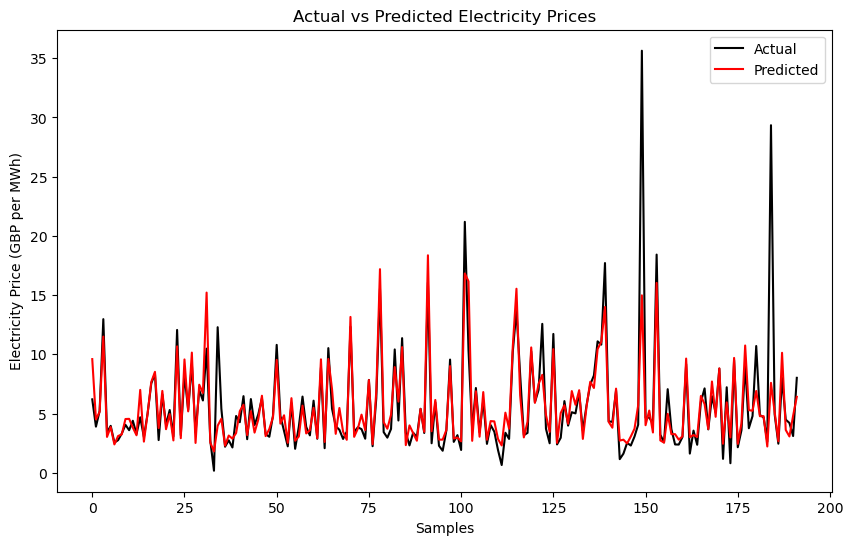

In [56]:
#increased param grid of n_estimator to 50, 100, 150 because previous tuning hits maximum range 
#for CV = 5 -> {'max_depth': 7, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 100}
#for CV = 10 -> {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 10}
#for CV = 10, criterio set to Sq error -> {'criterion': 'mse', 'max_depth': 13, 'min_samples_split': 2, 'n_estimators': 50}
#for CV = 20, {'criterion': 'squared_error', 'max_depth': 10, 'min_samples_split': 2, 'n_estimators': 50}
#RandomForestRegressor(n_estimators=10, max_depth = 7, criterion = 'squared_error', min_samples_split = 2, oob_score = True, random_state=42) ##

#model_1 = grid_search.best_estimator_ 
model_1 = RandomForestRegressor(n_estimators = 600, max_features = 'sqrt', max_depth = 10, random_state=42 , min_samples_split = 2)
model_1.fit(X_train, y_train)

y_pred_1 = model_1.predict(X_test)

r2_rf = r2_score(y_test, y_pred_1)
rmse_rf = np.sqrt(mean_squared_error(y_test, y_pred_1))
mae_rf = mean_absolute_error(y_test, y_pred_1)
mape_rf = np.mean(np.abs((y_test - y_pred_1) / y_test)) * 100
print("R^2 Score: " + str(r2_rf))
print("RMSE Score: " + str(rmse_rf))
print("MAE Score: " + str(mae_rf))
print("MAPE Score: " + str(mape_rf) + "%")

plt.figure(figsize=(10, 6))
plt.plot(y_test.values, label='Actual', color='black')
plt.plot(y_pred_1, label='Predicted', color='red')
plt.title('Actual vs Predicted Electricity Prices')
plt.xlabel('Samples')
plt.ylabel('Electricity Price (GBP per MWh)')
plt.legend()
plt.show()


# Hyperparameters Tuning for RF using Randomised Search, CV is lower due to computation limits

In [29]:
model_tuning = RandomForestRegressor(random_state=42)
random_grid = {'bootstrap': [True, False],
               'max_depth': [10, 20, 30, 40, 50, 80, 100, None],
               'max_features': ['sqrt','log2', None],
               'min_samples_leaf': [1, 2, 4, 6],
               'min_samples_split': [2, 5, 10, 15],
               'n_estimators': [500, 800, 1100, 2000, 4000]}

rf_random = RandomizedSearchCV(estimator = model_tuning, param_distributions = random_grid, n_iter = 100, 
                               cv = 3, verbose=2, random_state=42, n_jobs = -1)
# Fit the random search model
rf_random.fit(X_train, y_train)
print(rf_random.best_params_)

Fitting 3 folds for each of 100 candidates, totalling 300 fits
{'n_estimators': 2000, 'min_samples_split': 15, 'min_samples_leaf': 6, 'max_features': 'sqrt', 'max_depth': 40, 'bootstrap': True}


In [20]:
model_1 = rf_random.best_estimator_ 
model_1.fit(X_train, y_train)

y_pred_1 = model_1.predict(X_test)

r2_rf = r2_score(y_test, y_pred_1)
rmse_rf = np.sqrt(mean_squared_error(y_test, y_pred_1))
mae_rf = mean_absolute_error(y_test, y_pred_1)
mape_rf = mean_absolute_percentage_error(y_test, y_pred_1)*100
print("R^2 Score: " + str(r2_rf))
print("RMSE Score: " + str(rmse_rf))
print("MAE Score: " + str(mae_rf))
print("MAPE Score: " + str(mape_rf) + "%")

plt.figure(figsize=(10, 6))
plt.plot(y_test.values, label='Actual', color='black')
plt.plot(y_pred_1, label='Predicted', color='red')
plt.title('Actual vs Predicted Electricity Prices')
plt.xlabel('Samples')
plt.ylabel('Electricity Price (GBP per MWh)')
plt.legend()
plt.show()

NameError: name 'rf_random' is not defined

# Features Importance Analysis using Recursive Elimination Features approach

In [77]:
feature_importances = model.feature_importances_

for feature_name, score in zip(X_train.columns, feature_importances):
    print(f'{feature_name}: {score}')

electricity_demand_in_MWh: 0.1836930506327621
system_avg_price_gas_pence_per_kWh: 0.5293292287370055
carbon_price_EUR: 0.28697772063023247


In [72]:
X = data.drop(['day_auction_price_GBP_per_MWh','date', 'gdp', 'temperature_deg', 'wind_speed_ms','uranium_price_usd_per_lb' ], axis=1)
y = data['day_auction_price_GBP_per_MWh']
#X_valid = testing.drop("Id", axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

#re-run the models above

In [75]:
X = data.drop(['day_auction_price_GBP_per_MWh','date', 'gas_t', 'gdp', 'temperature_deg', 'wind_speed_ms','ccgt_generation_in_MWh','nuclear_generation_in_MWh', 'wind_generation_in_MWh','biomass_generation_in_MWh', 'uranium_price_usd_per_lb', 'crude_oil'  ], axis=1)
y = data['day_auction_price_GBP_per_MWh']
#X_valid = testing.drop("Id", axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

#re-run the models above

In [78]:
X = data.drop(['day_auction_price_GBP_per_MWh','date', 'system_avg_price_gas_pence_per_kWh', 'gdp', 'temperature_deg', 'wind_speed_ms','ccgt_generation_in_MWh','nuclear_generation_in_MWh', 'wind_generation_in_MWh','biomass_generation_in_MWh', 'uranium_price_usd_per_lb', 'crude_oil', 'electricity_demand_in_MWh'  ], axis=1)
y = data['day_auction_price_GBP_per_MWh']
#X_valid = testing.drop("Id", axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

#re-run the models above

# Removing Outliner from the data set

In [112]:
mean = data['day_auction_price_GBP_per_MWh'].mean()
print(mean)
data.loc[data['day_auction_price_GBP_per_MWh'] > 17.5, 'day_auction_price_GBP_per_MWh'] = mean
data.loc[data['day_auction_price_GBP_per_MWh'] <= 0, 'day_auction_price_GBP_per_MWh'] = mean

5.7259578125


In [27]:
scores_rf = cross_val_score(model_1, X_train, y_train, cv=10, scoring="r2")
print("Cross Validation Score: " + str(np.mean(scores_rf)))

Cross Validation Score: 0.6163193320611315


In [22]:
scores_rf = cross_val_score(model, X_train, y_train, cv=10, scoring="r2")
print("Cross Validation Score: " + str(np.mean(scores_rf)))

Cross Validation Score: 0.5743375871975959
